In [1]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from model import FiringRateModel, PolynomialActivation
from evaluate import explained_variance_ratio
from data import get_data, get_train_test_data, preprocess_data
from utils import plot_predictions, plot_kernel, plot_activation

pd.set_option('display.max_rows', None)

In [ ]:
data = get_data(563028422)
Is, fs = preprocess_data(data, 20)
plt.scatter(Is, fs)

In [2]:
params = {}
save_path = "model/params/"
#save_path = "model/params_bin_size_100_activation/"
for fname in os.listdir(save_path):
    with open(f"{save_path}{fname}", "rb") as f:
        p = pickle.load(f)
        params[int(fname.split(".")[0])] = p
        
print(len(params))

1033


Total number of cells: 1033
Number/proportion of cells with evr=0: 217/0.21006776379477252
Number/proportion of cells with epochs<50: 215/0.20813165537270087
Median evr: 0.7079724901391735


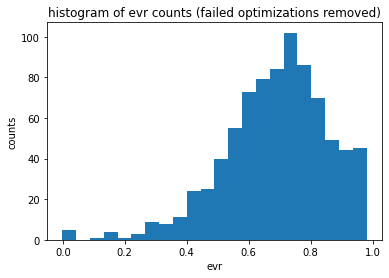

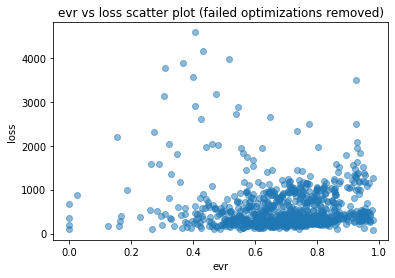

In [3]:
data = {"cell_id": [], "evr": [], "loss": [], "epochs": []}

for cell_id in params:
    data["cell_id"].append(cell_id)
    data["evr"].append(params[cell_id]["evr"])
    data["loss"].append(params[cell_id]["losses"][-1])
    data["epochs"].append(len(params[cell_id]["losses"]))

df = pd.DataFrame(data)
df = df.set_index("cell_id")
df = df.sort_values("evr")

print(f"Total number of cells: {len(df)}")
print(f"Number/proportion of cells with evr=0: {df['evr'].value_counts()[0]}/{df['evr'].value_counts()[0] / len(df)}")
print(f"Number/proportion of cells with epochs<50: {len(df[df['epochs'] < 50])}/{len(df[df['epochs'] < 50]) / len(df)}")

df_corrected = df[df["epochs"] > 50]
print(f"Median evr: {np.median(df_corrected['evr'].values)}")

plt.figure()
plt.hist(df_corrected["evr"].values, bins="auto")
plt.xlabel("evr")
plt.ylabel("counts")
plt.title("histogram of evr counts (failed optimizations removed)")

evrs = df_corrected.iloc[:, 0]
losses = df_corrected.iloc[:, 1]
plt.figure()
plt.scatter(evrs, losses, alpha=0.5)
plt.xlabel("evr")
plt.ylabel("loss")
plt.title("evr vs loss scatter plot (failed optimizations removed)");

In [ ]:
df

In [4]:
def load_model(params):
    g = PolynomialActivation()
    g.init_from_params(params["g"])
    model = FiringRateModel(g, [])
    model.init_from_params(params)
    return model

def visualize(cell_id, params, bin_size=20):
    model = load_model(params[cell_id]["params"])
    data = get_data(cell_id, aligned=True)
    Is_tr, fs_tr, Is_te, fs_te, stims = get_train_test_data(data, bin_size)
    Is_actv, fs_actv = preprocess_data(data, bin_size=params[cell_id]["params"]["g"]["bin_size"])
    
    for Is, fs, s in zip(Is_tr, fs_tr, stims):
        for i in range(Is.shape[0]):
            plot_predictions(
                model, 
                Is[i, :], 
                fs[i, :], 
                cell_id, 
                bin_size, 
                evr = None,
                save = False
            )

    r = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size)
    rq = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size, quantize=True)
    plot_predictions(
        model, 
        Is_te[0][0, :], 
        fs_te[0][0, :], 
        cell_id, 
        bin_size, 
        evr = (r, rq),
        save = False
    )

    plot_kernel(
        model,
        cell_id,
        bin_size,
        save = False
    )
    
    plot_activation(
        Is_actv,
        fs_actv,
        model.g
    )
    
    losses = params[cell_id]["losses"]
    plt.figure()
    plt.plot(list(range(len(losses))), losses)
    plt.xlabel("epochs")
    plt.ylabel("loss")

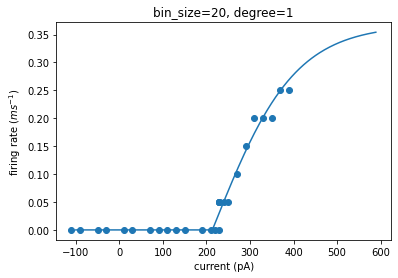

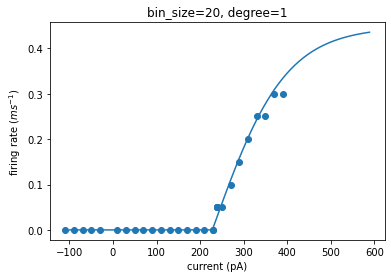

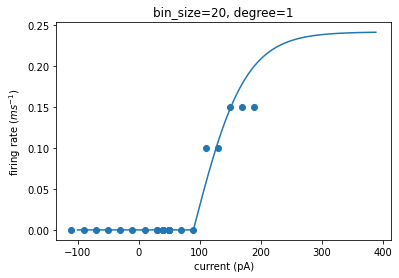

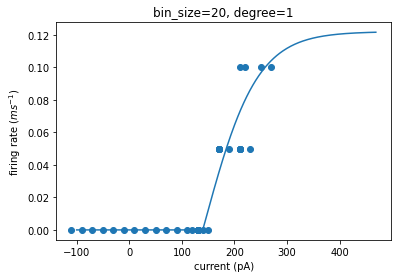

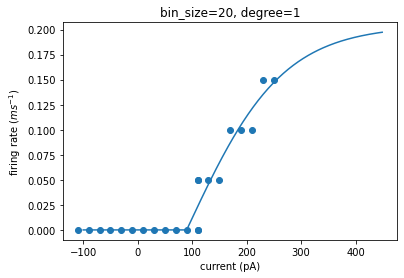

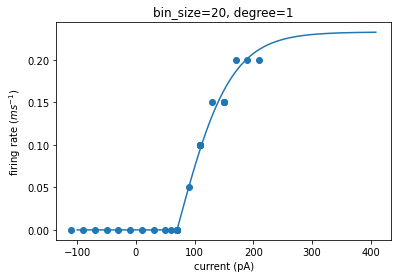

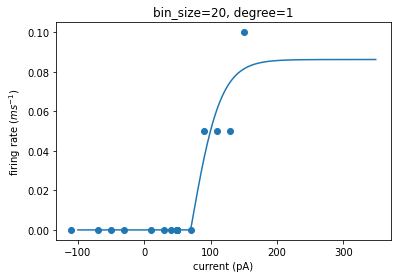

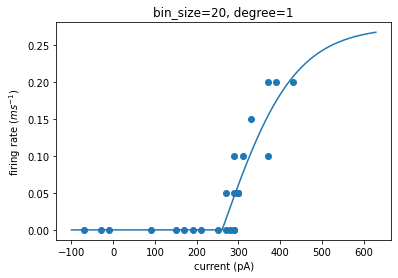

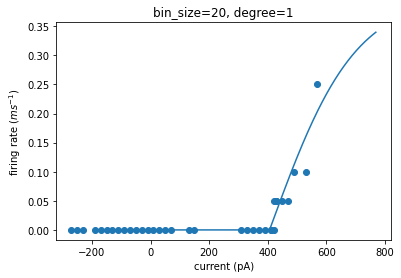

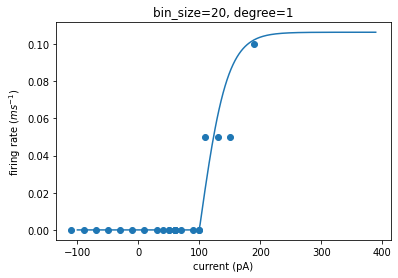

In [17]:
ok_cells = []

for cell_id in df[df["epochs"] < 10].index:
    model = load_model(params[cell_id]["params"])
    data = get_data(cell_id, aligned=True)
    Is_actv, fs_actv = preprocess_data(data, bin_size=params[cell_id]["params"]["g"]["bin_size"])
    
    if np.sum(fs_actv) > 0.0001:
        plot_activation(
            Is_actv,
            fs_actv,
            model.g
        )
        
        ok_cells.append(cell_id)

In [18]:
len(ok_cells)

10

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
visualize(476129135, params)

In [ ]:
a = set(df.index.tolist())
b = set(map(int, df[df["epochs"] < 50].index.tolist()))
c = set(map(int, np.genfromtxt("misc/valid_ids.csv", delimiter=",").tolist()))

In [ ]:
d = list((c - a).union(b))

In [ ]:
with open("misc/cell_ids_to_process.csv", "w") as f:
    f.write(",".join(map(str, d)))

In [ ]:
len(d)